take out blocks of 4 consecutive weeks to cross-validate the simple persistence model 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.neighbors import BallTree
import cartopy.crs as ccrs
import re
import tilemapbase
import cmocean
from forecast_clarify.config import *
import os

In [2]:
fpath = os.path.join(dirs['figures'],'visualisation')
fbase = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m/NorKyst-800m_ZDEPTHS_avg.an.2022091900.nc'

In [3]:
f = open('/projects/NS9853K/DATA/BarentsWatch/sites.json')
data = json.load(f)

sites_lat = [d['lat'] for d in data]
sites_lon = [d['lon'] for d in data]
sites_name = [d['name'] for d in data]
sites_locID = [d['localityNo'] for d in data]

langoey = [(d['name'],d['lat'],d['lon']) for d in data if 'Langøy ' in d['name']]

In [26]:
cl_name, cl_lat, cl_lon = [d['name'] for d in data if d['localityNo'] == 22095], [d['lat'] for d in data if d['localityNo'] == 22095], [d['lon'] for d in data if d['localityNo'] == 22095]

In [4]:
DS = xr.open_dataset(fbase)

In [5]:
DS.projection_stere

<xarray.DataArray 'projection_stere' ()>
array(-2147483647, dtype=int32)
Attributes:
    grid_mapping_name:                      polar_stereographic
    scale_factor_at_projection_origin:      0.9330127018922193
    straight_vertical_longitude_from_pole:  70.0
    latitude_of_projection_origin:          90.0
    false_easting:                          3192800.0
    false_northing:                         1784000.0
    semi_major_axis:                        6378137.0
    semi_minor_axis:                        6356752.3142
    proj4:                                  +proj=stere +ellps=WGS84 +lat_0=9...

In [6]:
DS.sel(depth=3).squeeze().temperature.stack(z=['Y','X'])

<xarray.DataArray 'temperature' (z: 2347004)>
array([      nan,       nan,       nan, ..., 3.7099998, 3.7099998,
       3.72     ], dtype=float32)
Coordinates:
    depth    float64 3.0
    time     datetime64[ns] 2022-09-19T12:00:00
    lat      (z) float64 55.91 55.91 55.92 55.93 55.93 ... 75.3 75.3 75.31 75.32
    lon      (z) float64 9.195 9.201 9.207 9.213 ... 23.65 23.67 23.69 23.71
  * z        (z) MultiIndex
  - Y        (z) float64 0.0 0.0 0.0 0.0 ... 7.208e+05 7.208e+05 7.208e+05
  - X        (z) float64 0.0 800.0 1.6e+03 ... 2.079e+06 2.08e+06 2.081e+06
Attributes:
    units:          Celsius
    time:           ocean_time
    grid:           grid
    location:       face
    field:          temperature, scalar, series
    grid_mapping:   projection_stere
    long_name:      Sea water potential temperature
    standard_name:  sea_water_potential_temperature
    _ChunkSizes:    [   1    1   17 2602]

In [7]:
lon_coo = 'lon'
lat_coo = 'lat'

In [8]:
try:
    lon_0 = int(re.search('lon_0=([\+-]?\d+)', DS.polar_stereographic.proj4_string).groups()[0])
    true_lat = int(re.search('lat_ts=([\+-]?\d+)', DS.polar_stereographic.proj4_string).groups()[0])
except:
    lon_0 = int(re.search('lon_0=([\+-]?\d+)', DS.projection_stere.proj4).groups()[0])
    true_lat = int(re.search('lat_ts=([\+-]?\d+)', DS.projection_stere.proj4).groups()[0])

In [9]:
# Projection may vary
proj = ccrs.NorthPolarStereo(
    central_longitude = lon_0,
    true_scale_latitude = true_lat,
)
transform = np.vectorize(lambda x, y: proj.transform_point(x,y, ccrs.PlateCarree()))

In [10]:
# The grid should be aligned such that the projection x and y are the same
# at every y and x index respectively
grid_y = DS.isel(X=0)
grid_x = DS.isel(Y=0)

_, proj_y = transform(grid_y[lon_coo], grid_y[lat_coo])
proj_x, _ = transform(grid_x[lon_coo], grid_x[lat_coo])

# ds.sel only works on the dimensions, so we can't just add
# proj_x and proj_y as additional coordinate variables
DS['X'] = proj_x
DS['Y'] = proj_y

In [11]:
proj_x_ext,proj_y_ext = np.meshgrid(proj_x,proj_y)
x_ix_ext,y_ix_ext = np.meshgrid(np.arange(len(proj_x)),np.arange(len(proj_y)))
t3m_MASK = ~np.isnan(DS.isel(time=0).sel(depth=3).temperature)
# t3m_MASK = DS.mask == 1
mask_flat = t3m_MASK.values.flatten() # 0: Land, 1: Ocean

xy_coords = np.stack([proj_x_ext.flatten(),proj_y_ext.flatten()],-1)
xy_ind = np.stack([x_ix_ext.flatten(),y_ix_ext.flatten()],-1)
xy_coords_nonnan = xy_coords[mask_flat,:]
xy_ind_nonnan = xy_ind[mask_flat,:]

In [12]:
desired_x, desired_y = transform(langoey[0][2], langoey[0][1])
desired_x, desired_y = transform(sites_lon, sites_lat)

In [13]:
# use BallTree instead:
tree   = BallTree(xy_coords_nonnan,metric="minkowski")
dist,k_indices = tree.query(np.stack([desired_x, desired_y],-1),return_distance=True) # .reshape(1, -1)
k_indices = k_indices.squeeze()

In [14]:
x_ind_xr = xr.DataArray(xy_ind_nonnan[k_indices][:,0],dims='points')
y_ind_xr = xr.DataArray(xy_ind_nonnan[k_indices][:,-1],dims='points')

temp3m_stations = DS.isel(X=x_ind_xr,Y=y_ind_xr).sel(depth=3).temperature

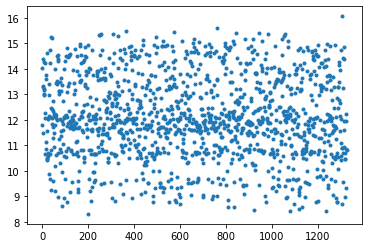

In [15]:
t3m = DS.sel(depth=3).temperature.values.squeeze()
lat = DS[lat_coo].values
lon = DS[lon_coo].values
t3m_stat = t3m[xy_ind_nonnan[k_indices][:,-1],xy_ind_nonnan[k_indices][:,0]]
lat_stat = lat[xy_ind_nonnan[k_indices][:,-1],xy_ind_nonnan[k_indices][:,0]]
lon_stat = lon[xy_ind_nonnan[k_indices][:,-1],xy_ind_nonnan[k_indices][:,0]]
plt.plot(t3m_stat,marker='.',ls='none')

In [16]:
tilemapbase.start_logging()

# Don't need if you have run before; DB file will already exist.
tilemapbase.init(create=True)

# Use open street map
t = tilemapbase.tiles.build_OSM()

# ext_lalo = [4,7,59,61.5]
ext_lalo = [4.875,6.5,59.6,60.5]

extent = tilemapbase.Extent.from_lonlat(*ext_lalo)

In [17]:
in_region = np.where(np.logical_and(np.array(sites_lat)<ext_lalo[3],np.array(sites_lat)>ext_lalo[2]) * np.logical_and(np.array(sites_lon)>ext_lalo[0],np.array(sites_lon)<ext_lalo[1]))
xtm,ytm,xtm_gp,ytm_gp = np.zeros([4,len(in_region[0])])
for ii,idx in enumerate(in_region[0]):
    xtm[ii],ytm[ii] = tilemapbase.project(np.array(sites_lon)[idx],np.array(sites_lat)[idx])
    xtm_gp[ii],ytm_gp[ii] = tilemapbase.project(lon_stat[idx],lat_stat[idx])

In [29]:
# close station:
xtm_cl,ytm_cl = tilemapbase.project(cl_lon[0],cl_lat[0])

In [18]:
mask_lon = (DS[lon_coo] >= ext_lalo[0]) & (DS[lon_coo] <= ext_lalo[1])
mask_lat = (DS[lat_coo] >= ext_lalo[2]) & (DS[lat_coo] <= ext_lalo[3])

cropped_ds = DS.where(mask_lon & mask_lat, drop=True)

x_tm_gr,y_tm_gr = np.zeros([2,*cropped_ds[lat_coo].shape])
for ii,(llo_gr,lla_gr) in enumerate(zip(cropped_ds[lon_coo],cropped_ds[lat_coo])):
    for jj,(llo,lla) in enumerate(zip(llo_gr,lla_gr)):
        x_tm_gr[ii,jj],y_tm_gr[ii,jj] = tilemapbase.project(llo,lla)

In [19]:
lon_name = lon_coo
lat_name = lat_coo

norkyst = DS.sel(depth=3).temperature.squeeze()
norkyst = norkyst.sortby(['X','Y'])
norkyst = norkyst.stack(point=['X','Y'])
norkyst = norkyst.dropna(dim="point",how="all")

bw_coords = np.deg2rad(np.stack([sites_lon,sites_lat],axis=-1))

# uncomment if you wanna look of each grid individually
coords = np.deg2rad(np.stack([norkyst[lon_name],norkyst[lat_name]],axis=-1))
tree_   = BallTree(coords,metric="haversine")
k_indices_ = tree_.query(bw_coords,return_distance=False).squeeze()

norkyst = norkyst.isel(point=k_indices_)

in_region = np.where(np.logical_and(norkyst[lat_name] < ext_lalo[3],norkyst[lat_name] > ext_lalo[2]) * np.logical_and(norkyst[lon_name] > ext_lalo[0],norkyst[lon_name] < ext_lalo[1]))
xtm_hvs,ytm_hvs = np.zeros([2,len(in_region[0])])
for ii,idx in enumerate(in_region[0]):
    xtm_hvs[ii],ytm_hvs[ii] = tilemapbase.project(norkyst[lon_name].values[idx],norkyst[lat_name].values[idx])
    
# norkyst = norkyst.drop(lat_name)
# norkyst = norkyst.drop(lon_name)
# norkyst = norkyst.assign_coords(point=bw_loc.location.values)
# norkyst = norkyst.assign_coords( loc_name=("point",bw_loc.loc_name.values) )
# norkyst = norkyst.assign_coords( loa
# n=("point",bw_loc.lon.values) )
# norkyst = norkyst.assign_coords( lat=("point",bw_loc.lat.values) )
# norkyst = norkyst.rename(dict(point="location"))

In [20]:
# Load an ERA
ds_era = xr.open_dataset('/projects/NS9001K/owul/projects/forecast_clarify/data/raw/sst_era5_20220912_hrly_snippet.nc')
sst_snippet = ds_era.mean('time').sst.values

lon_mesh, lat_mesh = np.meshgrid(ds_era['longitude'].values,ds_era['latitude'].values)

x_tm_era,y_tm_era = np.zeros([2,*lon_mesh.shape])
for ii,(llo_era,lla_era) in enumerate(zip(lon_mesh,lat_mesh)):
    for jj,(llo_,lla_) in enumerate(zip(llo_era,lla_era)):
        x_tm_era[ii,jj],y_tm_era[ii,jj] = tilemapbase.project(llo_,lla_)

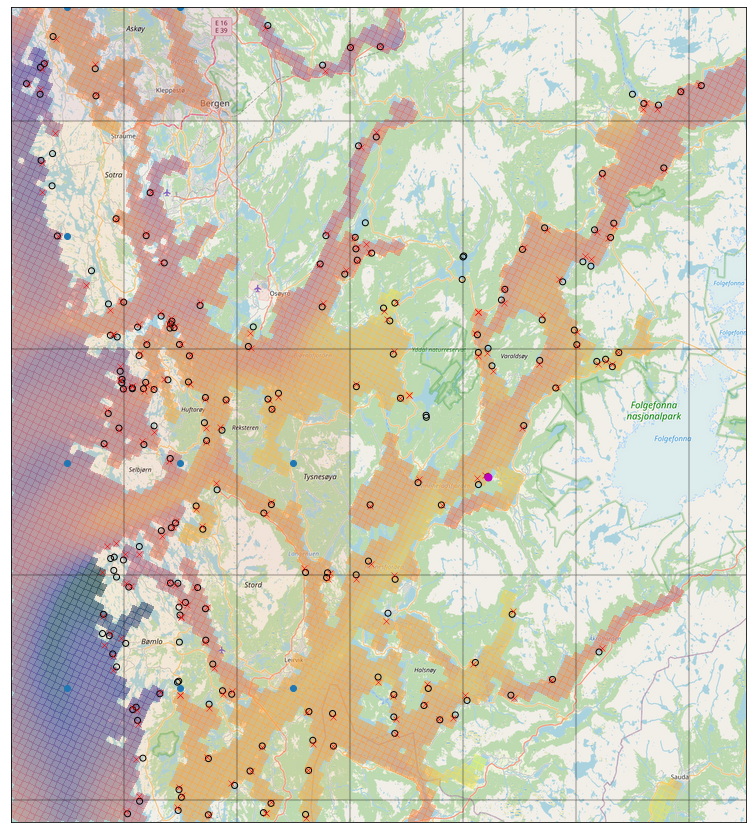

In [33]:
f,ax = plt.subplots(figsize=(15, 15))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t);

ax.pcolormesh(x_tm_gr,y_tm_gr,cropped_ds.temperature.sel(depth=3).isel(time=0),alpha=.5,shading='nearest',cmap=cmocean.cm.thermal)
ax.pcolormesh(x_tm_era,y_tm_era,sst_snippet,alpha=0.1,shading='nearest',cmap=cmocean.cm.thermal,edgecolor='k',linewidth=2)
ax.plot(x_tm_era.flat[np.isfinite(sst_snippet.flat)], y_tm_era.flat[np.isfinite(sst_snippet.flat)], 'o', color='C0')
ax.scatter(xtm,ytm, edgecolors='black',c='none')
# ax.scatter(xtm_gp,ytm_gp, marker='x', color='k',linewidth=.5)
ax.scatter(xtm_hvs,ytm_hvs, marker='x', color='r',linewidth=.5)
ax.scatter(xtm_cl,ytm_cl, marker='o', color='m',linewidth=2)


f.savefig(os.path.join(fpath,'stations_nk800_snippet_map.png'),dpi=300,bbox_inches='tight')
f.savefig(os.path.join(fpath,'stations_nk800_snippet_map.pdf'),bbox_inches='tight')
# ax.scatter(sites_lon,sites_lat,marker='x',c='red',transform=ccrs.PlateCarree())

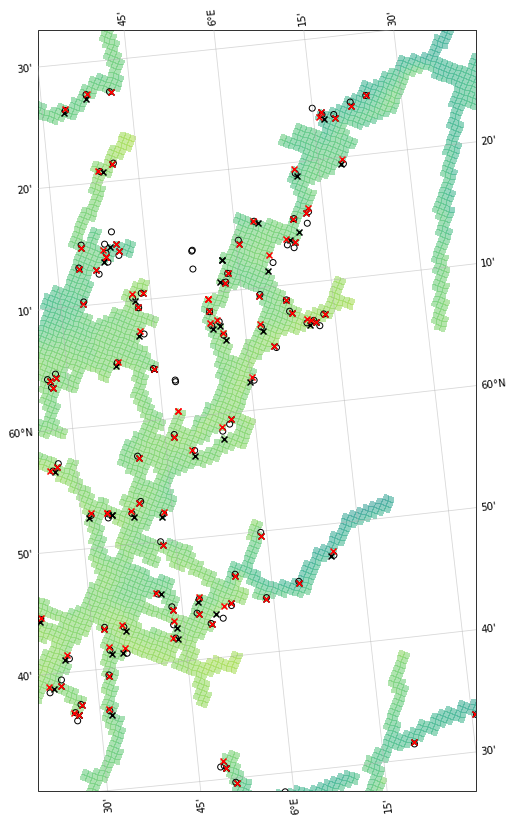

In [338]:
plt.figure(figsize=(14, 14))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent(ext_lalo)
# ax.set_extent([4.8,5.2,60.9,61.1])
plt.pcolormesh(DS.longitude,DS.latitude,DS.temperature.sel(depth=3).isel(time=0).values,transform=ccrs.PlateCarree(), alpha=.5)
ax.scatter(sites_lon,sites_lat, edgecolors='black',c='none',transform=ccrs.PlateCarree())
ax.scatter(lon_stat,lat_stat,marker='x',c='k',transform=ccrs.PlateCarree())
ax.scatter(norkyst.longitude,norkyst.latitude,marker='x',c='r',transform=ccrs.PlateCarree())
norkyst.latitude
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,zorder=7, alpha=.5)
# ax.scatter(nearest_point.longitude,nearest_point.latitude,marker='x',c='green')
# ax.scatter(nearest_point_ball.longitude,nearest_point_ball.latitude,marker='.',c='blue')

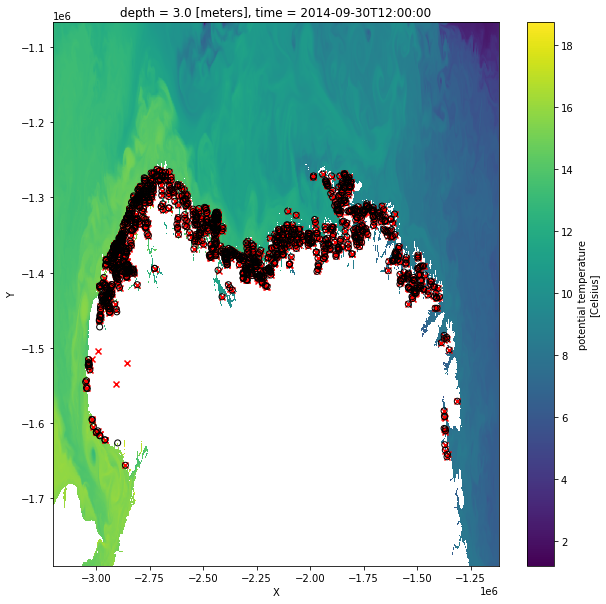

In [293]:
f,ax = plt.subplots(figsize=(10,10))
DS.temperature.sel(depth=3).isel(time=0).plot(ax=ax)
ax.scatter(desired_x,desired_y,marker='x',c='red')
ax.scatter(xy_coords_nonnan[k_indices][:,0],xy_coords_nonnan[k_indices][:,-1],c='none',edgecolor='k')
# ax.set_xlim([-3.1e6,-2.6e6])
# ax.set_ylim([-1.5e6,-1.25e6])

In [163]:
import seawater as sw

In [173]:
nearest_point

<xarray.Dataset>
Dimensions:                  (X: 2, Y: 2, depth: 17, time: 1)
Coordinates:
  * X                        (X) float64 -2.816e+06 -2.915e+06
  * Y                        (Y) float64 -1.322e+06 -1.272e+06
  * depth                    (depth) float32 0.0 3.0 10.0 ... 1e+03 2e+03 3e+03
  * time                     (time) datetime64[ns] 2019-02-25T12:00:00
    latitude                 (Y, X) float32 60.77 59.96 60.96 60.14
    longitude                (Y, X) float32 5.156 4.399 4.321 3.582
Data variables: (12/14)
    forecast_reference_time  datetime64[ns] 2019-02-25
    polar_stereographic      |S64 b''
    aice                     (time, Y, X) float32 0.02205 0.003029 ... 0.01161
    angle                    (Y, X) float32 1.132 1.145 1.146 1.159
    h                        (Y, X) float32 108.5 279.1 364.2 286.1
    hice                     (time, Y, X) float32 0.01336 0.002599 ... 0.008096
    ...                       ...
    temperature              (time, depth, Y, X) float32 4.837 6.563 ... nan nan
    u                        (time, depth, Y, X) float32 0.07234 0.2576 ... nan
    ubar                     (time, Y, X) float32 0.02045 0.1862 0.3267 -0.07219
    v                        (time, depth, Y, X) float32 0.0 -0.0351 ... nan nan
    vbar                     (time, Y, X) float32 0.0 0.005494 0.3144 0.1181
    zeta                     (time, Y, X) float32 -0.1972 -0.34 -0.3009 -0.3803
Attributes: (12/13)
    Conventions:              CF-1.4
    title:                    ROMS model results
    references:               http://www.myroms.org
    institution:              Norwegian Meteorological Institute, Niels Henri...
    history:                  Mon Feb 25 05:03:53 2019: ncks -O -d time,0,0 /...
    source:                   met.no ROMS model fields
    ...                       ...
    bulletin_type:            forecast
    forecast_reference_time:  1551052800
    grid_resolution:          0.8 kilometer
    grid_projection:          polar_stereographic
    NCO:                      "4.6.0"
    DODS.strlen:              0

In [164]:
theta = sw.temp(sal,temp,sw.pres(depth,lat),np.zeros_like(depth))

ValueError: operands could not be broadcast together with shapes (2,2) (17,) 

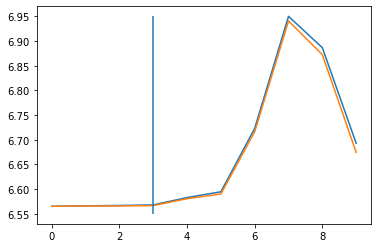

In [51]:
plt.plot(theta.T);
plt.plot(temp.T)
plt.vlines(3,6.55,6.95)